In [1]:
import numpy as np
from definitions import path_join, make_directory, EXPERIMENTS_DIR, VENSIM_MODELS_DIR, logging

In [2]:
args = {
    'model_name': 'teacup',
    'experiment_name': 'teacup_recovery',
    'need_retrain': False,
    'learning_rate': 1e-1,
    'epochs_before_decay': 0.1,
    'epochs_count': 50,
    'learning_rate_decay': 1/3,
    'iterations_count': 50,
}

In [5]:
KNOWN_MODEL = 'unknown model'

In [6]:
import tensorflow as tf

general_params = \
    {
        'phi_h': tf.keras.activations.linear,
        'phi_o': tf.keras.activations.linear,
    }

train_params = \
    {
        'learning_rate': args['learning_rate'],
        'epochs_before_decay': args['epochs_before_decay'],
        'epochs_count': args['epochs_count'],
        'learning_rate_decay': args['learning_rate_decay'],
    }


In [7]:
model_name = args['model_name']
need_train = bool(args['need_retrain'])
mode = KNOWN_MODEL

experiment_name = args['experiment_name']
experiment_dir = path_join(EXPERIMENTS_DIR, experiment_name)
make_directory(experiment_dir)

tf_model_dir = path_join(experiment_dir, 'tf_model')
make_directory(tf_model_dir)

images_dir = path_join(experiment_dir, 'images')
make_directory(images_dir)

log_path = path_join(experiment_dir, 'log.log')
logging.basicConfig(filename=log_path, level=logging.INFO)

vensim_model_file = path_join(VENSIM_MODELS_DIR, '{}.mdl'.format(model_name))

prn_model_dir = path_join(tf_model_dir, 'prn_model')
nn_model_dir = path_join(tf_model_dir, 'base_nn_model')
make_directory(prn_model_dir)
make_directory(nn_model_dir)

dataset_file = '{}_dataset.csv'.format(model_name)

In [8]:
from module.fd_model.vensim_fd_converter import get_fd

FD = get_fd(vensim_model_file, mode=mode)

ImportError: cannot import name 'get_fd'

In [13]:
import pandas as pd

data = pd.read_csv(dataset_file)
data.head(10)

,sim_index,Characteristic Time,Room Temperature,Teacup Temperature
0,0,10,45,140.00
1,0,10,45,138.81
2,0,10,45,137.64
3,0,10,45,136.48
4,0,10,45,135.34
5,0,10,45,134.21
6,0,10,45,133.09
7,0,10,45,131.99
8,0,10,45,130.91
9,0,10,45,129.83


In [14]:
fields = [level for level in FD.names_units_map.keys()]
fields

['Teacup Temperature', 'Characteristic Time', 'Room Temperature']

In [15]:
from sklearn.model_selection import train_test_split


def np_preproc_for_rnn3d(numpy_array, fields):
    x_groups = [group[1][fields].values[:-1] for group in numpy_array]
    y_groups = [group[1][fields].values[1:] for group in numpy_array]
    
    train_X, valid_X, train_y, valid_y = train_test_split(x_groups, y_groups, test_size=0.2, random_state=123)
    
    train_X = np.concatenate(train_X, axis=0)
    valid_X = np.concatenate(valid_X, axis=0)
    
    train_y = np.concatenate(train_y, axis=0)
    valid_y = np.concatenate(valid_y, axis=0)

    return (train_X, train_y), (valid_X, valid_y)


def generate_train_data(df, fields):
    dataset = df[fields].values
    grouped = df.groupby(['sim_index'])[fields]
    
    return dataset, np_preproc_for_rnn3d(grouped, fields)

In [16]:
_, (prn_train, prn_valid) = generate_train_data(data, fields)

In [17]:
prn_train_X, prn_train_y = prn_train
prn_valid_X, prn_valid_y = prn_valid

In [18]:
import tensorflow as tf
from tensorflow.python.framework import ops

ops.reset_default_graph()

In [19]:
from module.fd_model.fd_rnn_converter import FDRNNConverter
# from module.nn_model import NNModel as NNModelv1
from module.nn_model_tf_v2 import NNModel as NNModelv2
# from module.nn_model_with_regularizer import NNModel as NNModelv3
from module.nn_model_tf_v3 import NNModel as NNModelv3
from module.nn_model_tf_v21 import NNModel as NNModelv21

choosed_model = NNModelv2

In [20]:
FDRNN_converter = FDRNNConverter(general_params['phi_h'], general_params['phi_o'])
rnn_model = FDRNN_converter.fd_to_rnn(FD, choosed_model)

In [21]:
FD.levels

['Teacup Temperature']

In [22]:
FD.constants

['Characteristic Time', 'Room Temperature']

In [23]:
FD.rates

[rate : Heat Loss to Room
 flow : start : Teacup Temperature,	end : None
 
 Characteristic Time : 1
 Room Temperature : -1
 Teacup Temperature : 1
 ]

In [25]:
initial_value = np.reshape(prn_valid_X[0], [1, prn_valid_X.shape[1]])
initial_value

array([[40., 10., 70.]])

In [29]:
iterations_count = args['iterations_count']
if iterations_count == 0:
    iterations_count = X.shape[0] - 1
iterations_count

50

In [30]:
prn_iterative = rnn_model.get_simulation(initial_value, iterations_count, prn_model_dir)

In [31]:
prn_iterative.shape

(51, 3)

<Figure size 432x288 with 0 Axes>

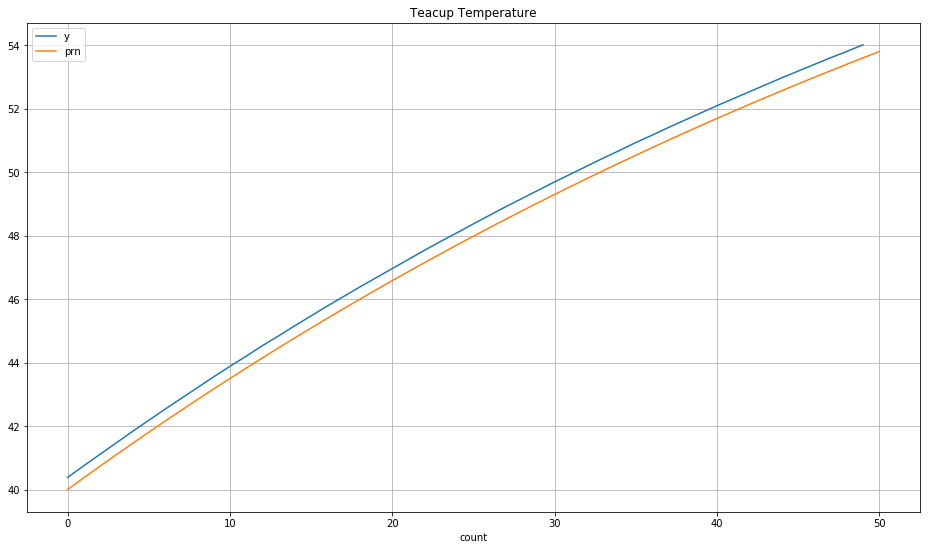

In [33]:
import matplotlib.pyplot as plt

plt.clf()

plt.figure(figsize=(16, 9))
column = 0

plt.title(fields[column])
plt.xlabel('time')
plt.xlabel('count')
plt.plot(prn_valid_y[:iterations_count, column], label='y')
plt.plot(prn_iterative[:, column], label='prn')
# plt.plot(nn_iterative[:, column], label='nn')
plt.grid()
plt.legend()

In [36]:
import tensorflow as tf

In [37]:
def parse_weights(gate, w, fields):
    equations = []
    for col_idx in range(gate.shape[1]):
        equation = ''
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 0:
                sign = '*' if w[row_idx, col_idx] > 0 else '/'
                weight = np.abs(w[row_idx, col_idx])
                weight = '' if weight == 1 else weight
                equation += '{}{}{}'.format(sign, weight, fields[row_idx])
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 1:
                sign = '+' if w[row_idx, col_idx] > 0 else '-'
                weight = np.abs(w[row_idx, col_idx])
                weight = '' if weight == 1 else weight
                equation += '{}{}{}'.format(sign, weight, fields[row_idx])

        equations.append(equation)
    return equations

In [41]:
_gate = np.array(tf.round(rnn_model.model.gate), dtype=np.int32)
_w = np.array(tf.round(rnn_model.model.W_ah), dtype=np.int32)
# print(fields)
parse_weights(_gate, _w, fields)

['/Characteristic Time']

In [44]:
tf.round(tf.math.sigmoid(rnn_model.model.gate))

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [0.]], dtype=float32)>